<a href="https://colab.research.google.com/github/tcg02/stockprediction/blob/master/stockprediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#This program uses LSTM to predict stock closing price.


In [ ]:
#import required libs
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [ ]:
#get the stock quote
df = web.DataReader('AAPL', data_source = 'yahoo', start='2016-01-01',end='2021-04-12')
#show the data
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-01-04,26.342501,25.500000,25.652500,26.337500,270597600.0,24.364536
2016-01-05,26.462500,25.602501,26.437500,25.677500,223164000.0,23.753977
2016-01-06,25.592501,24.967501,25.139999,25.174999,273829600.0,23.289116
2016-01-07,25.032499,24.107500,24.670000,24.112499,324377600.0,22.306208
2016-01-08,24.777500,24.190001,24.637501,24.240000,283192000.0,22.424154
...,...,...,...,...,...,...
2021-04-06,127.129997,125.650002,126.500000,126.209999,80171300.0,126.209999
2021-04-07,127.919998,125.139999,125.830002,127.900002,83466700.0,127.900002
2021-04-08,130.389999,128.520004,128.949997,130.360001,88844600.0,130.360001


In [ ]:
df.shape

(1327, 6)

Text(0, 0.5, 'Close Price USD ($)')

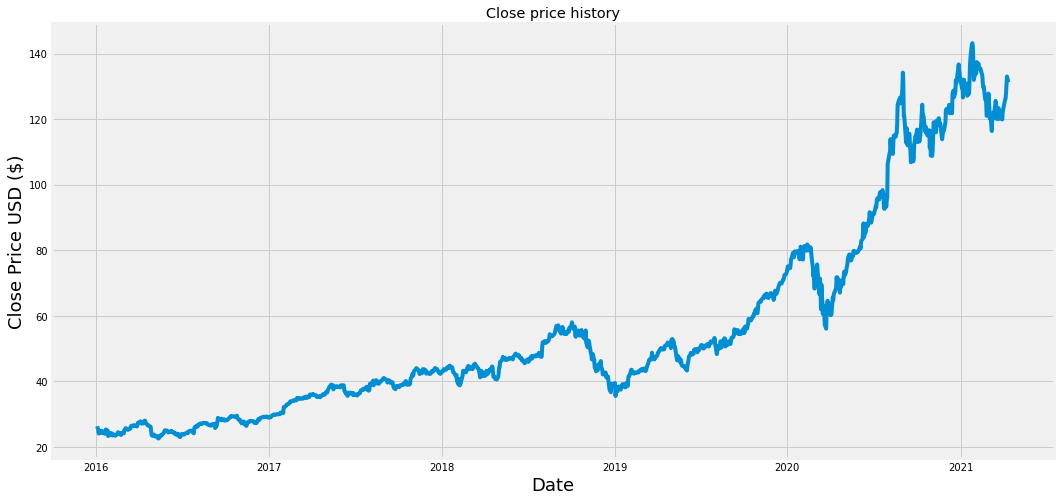

In [ ]:
#visualize the closing price history
plt.figure(figsize=(16,8))
plt.title('Close price history')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)

In [ ]:
#create a new dataframe with only closing price
data = df.filter(['Close'])
#convert dataframe to numpy array
dataset = data.values
#Get the number of rows to train the model on
training_data_len = math.ceil(len(dataset) * 0.8)

time_steps = 60

In [ ]:
#Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.03112171],
       [0.02564794],
       [0.02148041],
       ...,
       [0.89384199],
       [0.91573707],
       [0.90114039]])

In [ ]:
#Create training data set
#Create the scaled training data set
train_data =scaled_data[0:training_data_len, :]
#split the data into x_train and y_train data sets

x_train = []
y_train = []

for i in range(time_steps, len(train_data)):
  x_train.append(train_data[i-time_steps:i,0])
  y_train.append(train_data[i, 0])  

In [ ]:
#Convert x_train and y_train to numpy array
x_train,y_train = np.array(x_train), np.array(y_train)

In [ ]:
#Reshape the data as LSTM expect data to be 3D
x_train = np.reshape(x_train, (x_train.shape[0], time_steps, 1))
x_train.shape


(1002, 60, 1)

In [ ]:
#Build the LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_steps,1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))


In [ ]:
#Compile Model
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
#Train 
model.fit(x_train,y_train, batch_size=1, epochs=10)

Epoch 1/10
1002/1002 [==============================] - 24s 21ms/step - loss: 0.0011
Epoch 2/10
1002/1002 [==============================] - 21s 21ms/step - loss: 4.0681e-04
Epoch 3/10
1002/1002 [==============================] - 21s 21ms/step - loss: 3.0957e-04
Epoch 4/10
1002/1002 [==============================] - 21s 21ms/step - loss: 3.0508e-04
Epoch 5/10
1002/1002 [==============================] - 21s 21ms/step - loss: 1.7382e-04
Epoch 6/10
1002/1002 [==============================] - 20s 20ms/step - loss: 2.3320e-04
Epoch 7/10
1002/1002 [==============================] - 21s 21ms/step - loss: 1.3426e-04
Epoch 8/10
1002/1002 [==============================] - 20s 20ms/step - loss: 1.2930e-04
Epoch 9/10
1002/1002 [==============================] - 21s 20ms/step - loss: 1.6299e-04
Epoch 10/10
1002/1002 [==============================] - 21s 21ms/step - loss: 1.2847e-04


In [ ]:
#Create the testing data set

test_data = scaled_data[training_data_len - time_steps: , :]
#Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:,:]
for i in range(time_steps, len(test_data)):
  x_test.append(test_data[i-time_steps:i,0])

In [ ]:
#Convert the data to a numpy array
x_test = np.array(x_test)

In [ ]:
#Reshape the data
x_test = np.reshape(x_test,(x_test.shape[0],time_steps,1))


In [ ]:
#Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)


In [ ]:
#Evaluate the predictions using RMSE
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

1.8763321498654923

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


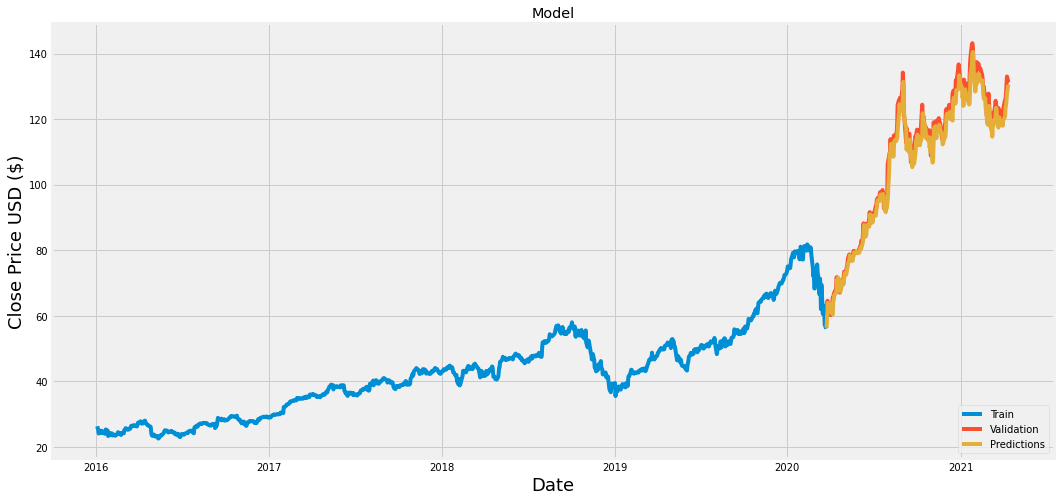

In [ ]:
#plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['predictions'] = predictions

#Visualize
plt.figure(figsize=(16,8))
plt.title('Model')      
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','predictions']])
plt.legend(['Train','Validation','Predictions'], loc='lower right')
plt.show()


In [ ]:
#Show the actual and prediceted prices
valid

,Close,predictions
Date,,
2020-03-24,61.720001,56.348278
2020-03-25,61.380001,60.071602
2020-03-26,64.610001,61.337124
2020-03-27,61.935001,63.967907
2020-03-30,63.702499,62.736530
...,...,...
2021-04-06,126.209999,123.496925
2021-04-07,127.900002,124.302597
2021-04-08,130.360001,125.630981
